<a href="https://colab.research.google.com/github/jfink09/DeepFundus/blob/main/Model_Ensamble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Setup train and testing paths
train_dir = Path("drive/MyDrive/data/train")
test_dir = Path("drive/MyDrive/data/test")

train_dir, test_dir

(PosixPath('drive/MyDrive/data/train'), PosixPath('drive/MyDrive/data/test'))

In [4]:
from torchvision import datasets, transforms

# Create simple transform
data_transform = transforms.Compose([ 
    #transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomInvert(),
    #transforms.TenCrop(64),
    transforms.ColorJitter(brightness=(0.5,1.5), contrast=(1), saturation=(0.5,1.5), hue=(-0.1,0.1)),
    transforms.RandomSolarize(threshold=192,p=0.5),
    transforms.ToTensor(),
])

# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 1246
    Root location: drive/MyDrive/data/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomInvert(p=0.5)
               ColorJitter(brightness=(0.5, 1.5), contrast=[0.0, 2.0], saturation=(0.5, 1.5), hue=(-0.1, 0.1))
               RandomSolarize(threshold=192,p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 315
    Root location: drive/MyDrive/data/test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomInvert(p=0.5)
               ColorJitter(brightness=(0.5, 1.5), contrast=[0.0, 2.0], saturation=(0.5, 1.5), hue=(-0.1, 0.1))
               RandomSolarize(threshold=192,p=0.5)
               ToTensor()
           )


In [5]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [7]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/jfink09/optical-funduscopic-convolutional-neural-network
    !mv optical-funduscopic-convolutional-neural-network/going_modular .
    !rm -rf optical-funduscopic-convolutional-neural-network
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'optical-funduscopic-convolutional-neural-network'...
remote: Enumerating objects: 266, done.
remote: Total 266 (delta 0), reused 0 (delta 0), pack-reused 266
Receiving objects: 100% (266/266), 79.81 MiB | 38.97 MiB/s, done.
Resolving deltas: 100% (119/119), done.


In [8]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.5,1.5), contrast=(1), saturation=(0.5,1.5), hue=(-0.1,0.1)),
    transforms.RandomRotation(45),
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

import random
from PIL import Image
from pathlib import PurePath

image_path = Path("drive/MyDrive/data")
#image_path = data_path / "test/CRVO"

# Set seed
#random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)
#img

drive/MyDrive/data/train/Laser Spots/laserspot58.jpg
Laser Spots


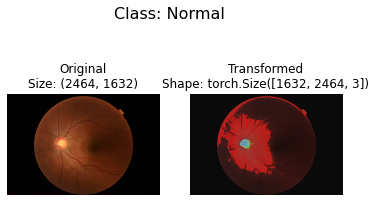

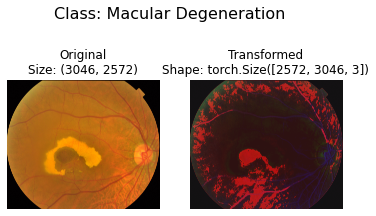

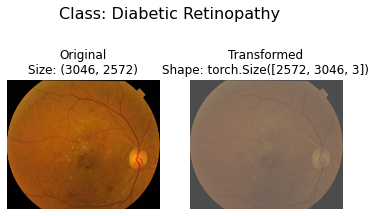

In [10]:
def plot_transformed_images(image_paths,transform,n=3,seed=42):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs. the transformed version.
  """
  if seed:
    #random.seed(seed)
    pass
  random_image_paths = random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot the target image
      transformed_image = transform(f).permute(1,2,0) # Will need to change the shape for matplotlib (C,H,W) -> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=False)

In [11]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fe3d92cc4f0>,
 ['CRVO',
  'Choroidal Nevus',
  'Diabetic Retinopathy',
  'Laser Spots',
  'Macular Degeneration',
  'Macular Hole',
  'Myelinated Nerve Fiber',
  'Normal',
  'Pathological Mypoia',
  'Retinitis Pigmentosa'])

In [12]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.5,1.5), contrast=(1), saturation=(0.5,1.5), hue=(-0.1,0.1)),
    transforms.RandomRotation(45),
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

# import random
# from PIL import Image
# from pathlib import PurePath

# image_path = Path("drive/MyDrive/data")
# #image_path = data_path / "test/CRVO"

# # Set seed
# #random.seed(42)

# # 1. Get all image paths
# image_path_list = list(image_path.glob("*/*/*.jpg"))
# image_path_list

# # 2. Pick a random image path
# random_image_path = random.choice(image_path_list)
# print(random_image_path)

# # 3. Get image class from path name (the image class is the name of the directory where the image is stored)
# image_class = random_image_path.parent.stem
# print(image_class)

# # 4. Open image
# img = Image.open(random_image_path)
# #img

In [14]:
# Get a set of pretrained model weights
weights_eff = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights_res = torchvision.models.ResNet50_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights_vgg = torchvision.models.VGG19_BN_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights_eff, weights_res, weights_vgg

(EfficientNet_B0_Weights.IMAGENET1K_V1,
 ResNet50_Weights.IMAGENET1K_V2,
 VGG19_BN_Weights.IMAGENET1K_V1)

In [15]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
#weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model_1 = torchvision.models.efficientnet_b0(weights=weights_eff).to(device)
model_2 = torchvision.models.resnet50(weights=weights_res).to(device)
model_3 = torchvision.models.vgg19_bn(weights=weights_vgg).to(device)

#model # uncomment to output (it's very long)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [22]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=2048, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

model_3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=25088, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [18]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.001)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.001)
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=0.001)

In [19]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results_1 = engine.train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer_1,
                        loss_fn=loss_fn,
                        epochs=10,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6469 | train_acc: 0.4408 | test_loss: 1.4688 | test_acc: 0.5052
Epoch: 2 | train_loss: 1.0458 | train_acc: 0.6453 | test_loss: 1.1318 | test_acc: 0.6354
Epoch: 3 | train_loss: 0.9445 | train_acc: 0.6670 | test_loss: 1.1515 | test_acc: 0.6155
Epoch: 4 | train_loss: 0.7851 | train_acc: 0.7393 | test_loss: 1.1462 | test_acc: 0.6485
Epoch: 5 | train_loss: 0.7072 | train_acc: 0.7640 | test_loss: 1.0838 | test_acc: 0.6823
Epoch: 6 | train_loss: 0.6393 | train_acc: 0.7923 | test_loss: 1.0257 | test_acc: 0.6789
Epoch: 7 | train_loss: 0.5955 | train_acc: 0.8019 | test_loss: 0.9698 | test_acc: 0.7323
Epoch: 8 | train_loss: 0.5137 | train_acc: 0.8283 | test_loss: 0.8328 | test_acc: 0.7534
Epoch: 9 | train_loss: 0.5161 | train_acc: 0.8292 | test_loss: 0.9368 | test_acc: 0.7147
Epoch: 10 | train_loss: 0.4485 | train_acc: 0.8490 | test_loss: 0.8258 | test_acc: 0.7678
[INFO] Total training time: 1332.162 seconds


In [20]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results_2 = engine.train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer_2,
                        loss_fn=loss_fn,
                        epochs=10,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2741 | train_acc: 0.3533 | test_loss: 2.1323 | test_acc: 0.4530
Epoch: 2 | train_loss: 1.2384 | train_acc: 0.5876 | test_loss: 1.5658 | test_acc: 0.4933
Epoch: 3 | train_loss: 1.0509 | train_acc: 0.6524 | test_loss: 1.4149 | test_acc: 0.5001
Epoch: 4 | train_loss: 0.8961 | train_acc: 0.6936 | test_loss: 1.2769 | test_acc: 0.6257
Epoch: 5 | train_loss: 0.8026 | train_acc: 0.7360 | test_loss: 1.4062 | test_acc: 0.5431
Epoch: 6 | train_loss: 0.7446 | train_acc: 0.7506 | test_loss: 1.5327 | test_acc: 0.5214
Epoch: 7 | train_loss: 0.7063 | train_acc: 0.7635 | test_loss: 1.4002 | test_acc: 0.5806
Epoch: 8 | train_loss: 0.6877 | train_acc: 0.7745 | test_loss: 1.3329 | test_acc: 0.6002
Epoch: 9 | train_loss: 0.7066 | train_acc: 0.7592 | test_loss: 1.2482 | test_acc: 0.6536
Epoch: 10 | train_loss: 0.6278 | train_acc: 0.7881 | test_loss: 1.0907 | test_acc: 0.6834
[INFO] Total training time: 1165.580 seconds


In [23]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results_3 = engine.train(model=model_3,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer_3,
                        loss_fn=loss_fn,
                        epochs=10,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8895 | train_acc: 0.3011 | test_loss: 2.0542 | test_acc: 0.3351
Epoch: 2 | train_loss: 1.6037 | train_acc: 0.4132 | test_loss: 2.0566 | test_acc: 0.3123
Epoch: 3 | train_loss: 1.4429 | train_acc: 0.4753 | test_loss: 1.7230 | test_acc: 0.4331
Epoch: 4 | train_loss: 1.2918 | train_acc: 0.5388 | test_loss: 1.6644 | test_acc: 0.4544
Epoch: 5 | train_loss: 1.1742 | train_acc: 0.5988 | test_loss: 1.6775 | test_acc: 0.4177
Epoch: 6 | train_loss: 1.1775 | train_acc: 0.6028 | test_loss: 1.5125 | test_acc: 0.5200
Epoch: 7 | train_loss: 1.0808 | train_acc: 0.6407 | test_loss: 1.4694 | test_acc: 0.5138
Epoch: 8 | train_loss: 1.0705 | train_acc: 0.6235 | test_loss: 1.4695 | test_acc: 0.5001
Epoch: 9 | train_loss: 0.9890 | train_acc: 0.6548 | test_loss: 1.7877 | test_acc: 0.4140
Epoch: 10 | train_loss: 0.9696 | train_acc: 0.6701 | test_loss: 1.3675 | test_acc: 0.5556
[INFO] Total training time: 1212.913 seconds


[INFO] Couldn't find helper_functions.py, downloading...


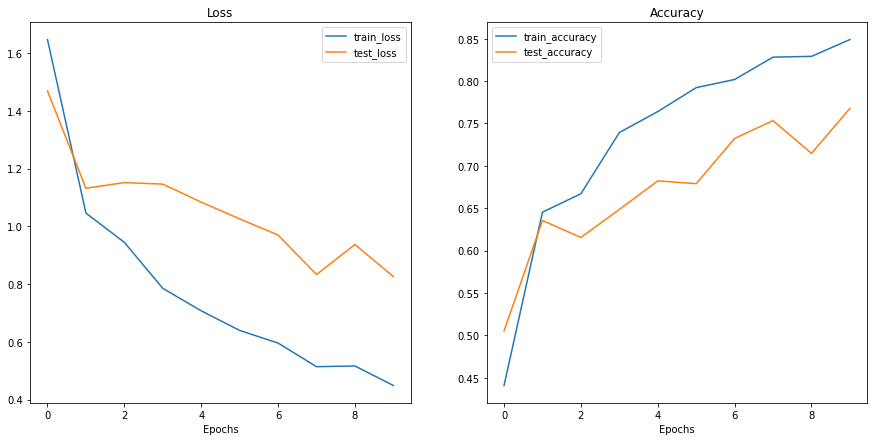

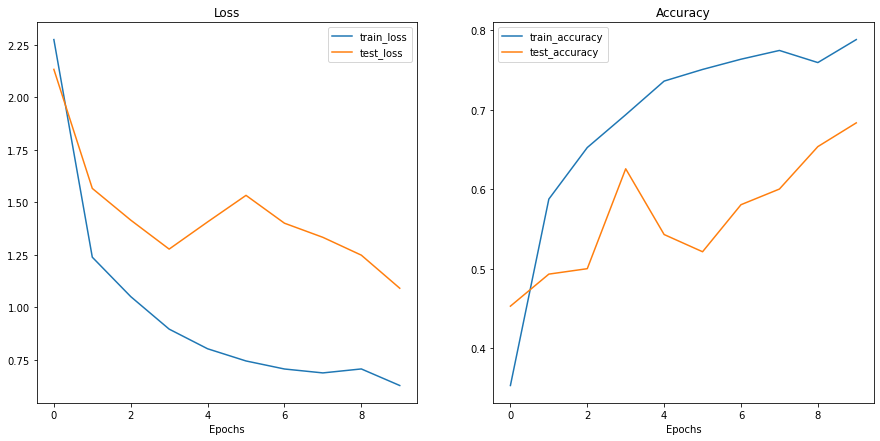

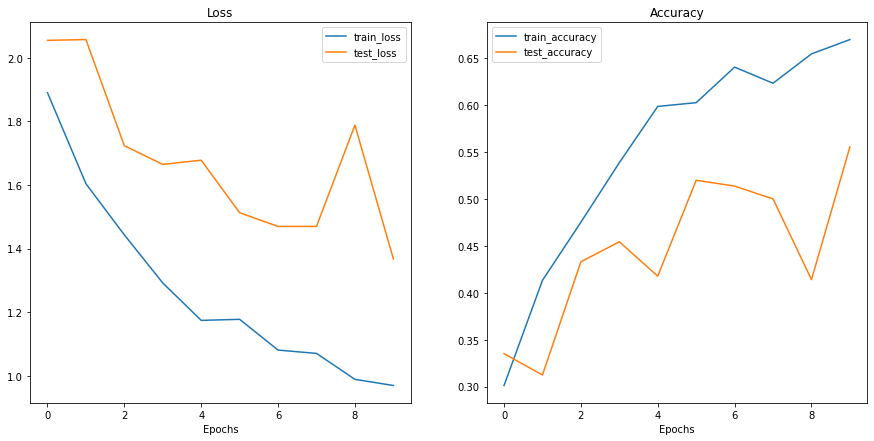

In [24]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://github.com/jfink09/optical-funduscopic-convolutional-neural-network/raw/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results_1)
plot_loss_curves(results_2)
plot_loss_curves(results_3)

In [70]:
import torch.nn as nn
import torch

class MyEnsemble(nn.Module):
  def __init__(self, model_1, model_2, model_3, output):
    super(MyEnsemble, self).__init__()
    self.model_1 = model_1
    self.model_2 = model_2
    self.model_3 = model_3
    
    self.fc1 = nn.Linear(10, output)

  def forward(self,x):
    out1 = self.model_1(x)
    out2 = self.model_2(x)
    out3 = self.model_3(x)

    out = out1 + out2 + out3
    x = torch.softmax(x, dim=1)
    return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import torchvision.models as models

densenet161 = models.densenet161(pretrained=True).to(device)
resnet101 = models.resnet101(pretrained=True).to(device)
googlenet = models.googlenet(pretrained=True).to(device)

densenet161.classifier = nn.Linear(in_features=densenet161.classifier.in_features, out_features=10)
resnet101.fc = nn.Linear(in_features=resnet101.fc.in_features, out_features=10)
googlenet.fc = nn.Linear(in_features=googlenet.fc.in_features, out_features=10)


criterion = nn.CrossEntropyLoss()

densenet161 = densenet161.to(device)
resnet101 = resnet101.to(device)
googlenet = googlenet.to(device)

optimizer_densenet161 = torch.optim.Adam(densenet161.parameters(), lr=0.001)
optimizer_resnet101 = torch.optim.Adam(resnet101.parameters(), lr=0.001)
optimizer_googlenet = torch.optim.Adam(googlenet.parameters(), lr=0.001)

densenet161, history, best_epoch = engine.train(densenet161, criterion, optimizer_densenet161, train_dataloader, test_dataloader, 2,device=device)
densenet = [densenet161, history, best_epoch]
resnet101, history, best_epoch = engine.train(resnet101, criterion, optimizer_resnet101, train_dataloader, test_dataloader, 2,device=device)
resnet = [resnet101, history, best_epoch]
googlenet, history, best_epoch = engine.train(googlenet, criterion, optimizer_googlenet, train_dataloader, test_dataloader, 2,device=device)
googlenet = [googlenet, history, best_epoch]

ensemble = MyEnsemble(densenet[1], resnet[1], googlenet[1], 10)

  0%|          | 0/2 [00:00<?, ?it/s]

TypeError: ignored

In [27]:
ensemble_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1020, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [28]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results_ensemble = engine.train(model=ensemble_model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer_1,
                        loss_fn=loss_fn,
                        epochs=10,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 10.1941 | train_acc: 0.0563 | test_loss: 9.9421 | test_acc: 0.0375
Epoch: 2 | train_loss: 10.0201 | train_acc: 0.0570 | test_loss: 9.7904 | test_acc: 0.0375
Epoch: 3 | train_loss: 10.1063 | train_acc: 0.0585 | test_loss: 9.9805 | test_acc: 0.0375
Epoch: 4 | train_loss: 10.4348 | train_acc: 0.0482 | test_loss: 9.9786 | test_acc: 0.0375
Epoch: 5 | train_loss: 10.2410 | train_acc: 0.0499 | test_loss: 9.7076 | test_acc: 0.0375
Epoch: 6 | train_loss: 10.2801 | train_acc: 0.0585 | test_loss: 9.8822 | test_acc: 0.0375
Epoch: 7 | train_loss: 10.2886 | train_acc: 0.0473 | test_loss: 9.8196 | test_acc: 0.0375
Epoch: 8 | train_loss: 10.1063 | train_acc: 0.0569 | test_loss: 9.9521 | test_acc: 0.0375
Epoch: 9 | train_loss: 10.2956 | train_acc: 0.0529 | test_loss: 9.8301 | test_acc: 0.0375
Epoch: 10 | train_loss: 10.0699 | train_acc: 0.0626 | test_loss: 9.8442 | test_acc: 0.0375
[INFO] Total training time: 1174.512 seconds


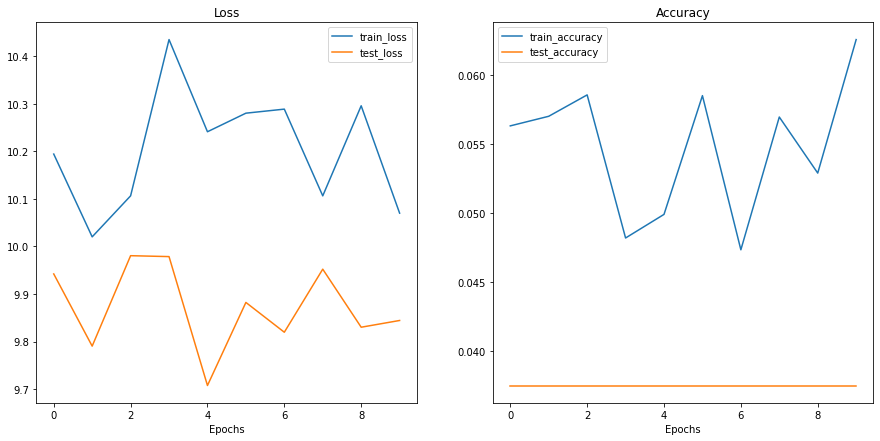

In [29]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://github.com/jfink09/optical-funduscopic-convolutional-neural-network/raw/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results_ensemble)

In [59]:
class MyEnsemble(nn.Module):

    def __init__(self, model_1, model_2, model_3, input):
        super(MyEnsemble, self).__init__()
        self.model_1 = model_1
        self.model_2 = model_2
        self.model_3 = model_3

        self.fc1 = nn.Linear(input, 16)

    def forward(self, x):
        out1 = self.model_1(x)
        out2 = self.model_2(x)
        out3 = self.model_3(x)

        out = out1 + out2 + out3

        x = self.fc1(out)
        return torch.softmax(x, dim=1)

In [ ]:
ensemble = MyEnsemble(model_1, model_2, model_3, 16)
ensemble.to(device)

In [49]:
optimizer = torch.optim.Adam(ensemble.parameters(),lr=0.003)
# turn this off
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [50]:
epoch = 10
loss = criterion(outputs,target)

In [53]:
!wget https://raw.githubusercontent.com/Iamsdt/DLProjects/master/utils/Helper.py
import Helper

--2023-02-22 02:46:48--  https://raw.githubusercontent.com/Iamsdt/DLProjects/master/utils/Helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21413 (21K) [text/plain]
Saving to: ‘Helper.py’

Helper.py           100%[===================>]  20.91K  --.-KB/s    in 0.002s  

2023-02-22 02:46:48 (13.2 MB/s) - ‘Helper.py’ saved [21413/21413]



In [55]:
ensemble, train_loss, test_loss = Helper.train(ensemble, train_dataloader, test_dataloader, epoch, optimizer, criterion)

Epoch: 1/10


RuntimeError: ignored

In [47]:
ensemble.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1020, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [48]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results_ensemble = engine.train(model=ensemble,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer_1,
                        loss_fn=loss_fn,
                        epochs=10,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

RuntimeError: ignored

In [30]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=model_1,
                 target_dir="models",
                 model_name="pretrained_efficientnet_b0_feature_extractor_drappcompressed.pth")
utils.save_model(model=model_2,
                 target_dir="models",
                 model_name="pretrained_resnet50_feature_extractor_drappcompressed.pth")
utils.save_model(model=model_3,
                 target_dir="models",
                 model_name="pretrained_vgg19_bn_feature_extractor_drappcompressed.pth")
utils.save_model(model=ensemble_model,
                 target_dir="models",
                 model_name="pretrained_ensemble_model_feature_extractor_drappcompressed.pth")

[INFO] Saving model to: models/pretrained_efficientnet_b0_feature_extractor_drappcompressed.pth
[INFO] Saving model to: models/pretrained_resnet50_feature_extractor_drappcompressed.pth
[INFO] Saving model to: models/pretrained_vgg19_bn_feature_extractor_drappcompressed.pth
[INFO] Saving model to: models/pretrained_ensemble_model_feature_extractor_drappcompressed.pth


In [31]:
import shutil
from pathlib import Path

# Create DeepFundus demo path
deepfundus_demo_path = Path("demos/deepfundus/")

# Remove files that might already exist there and create new directory
if deepfundus_demo_path.exists():
    shutil.rmtree(deepfundus_demo_path)
    deepfundus_demo_path.mkdir(parents=True, # make the parent folders?
                                    exist_ok=True) # create it even if it already exists?
else:
    # If the file doesn't exist, create it anyway
    deepfundus_demo_path.mkdir(parents=True, 
                                    exist_ok=True)
    
# Check what's in the folder
!ls demos/deepfundus/

In [ ]:
import shutil
from pathlib import Path

# 1. Create an examples directory
deepfundus_examples_path = deepfundus_demo_path / "examples"
deepfundus_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
deepfundus_examples = [Path('drive/MyDrive/data/test/CRVO/cr44.jpg'),
                            Path('drive/MyDrive/data/test/Macular Degeneration/mdegen228.jpg'),
                            Path('drive/MyDrive/data/test/Diabetic Retinopathy/dr240.jpg')]

# 3. Copy the three random images to the examples directory
for example in deepfundus_examples:
    destination = deepfundus_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(deepfundus_examples_path)]
example_list

In [ ]:
import shutil

# Create a source path for our target model
ensemble_model_deepfundus_model_path = "models/09_pretrained_ensemble_model_feature_extractor_drappcompressed.pth"

# Create a destination path for our target model 
ensemble_model_deepfundus_model_destination = deepfundus_demo_path / ensemble_model_deepfundus_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {ensemble_model_deepfundus_model_path} to {ensemble_model_deepfundus_model_destination}")
    
    # Move the model
    shutil.move(src=ensemble_model_deepfundus_model_path, 
                dst=ensemble_model_deepfundus_model_destination)
    
    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {ensemble_model_deepfundus_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {ensemble_model_deepfundus_model_destination}: {ensemble_model_deepfundus_model_destination.exists()}")

In [ ]:
%%writefile demos/deepfundus/model.py
import torch
import torchvision

from torch import nn

def create_ensemble_model(num_classes:int=10, # 4
                          seed:int=42):
    """Creates an EEnsemble Model feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): Ensemble Model feature extractor model. 
        transforms (torchvision.transforms): Ensemble Model image transforms.
    """
    # 1, 2, 3. Create Ensemble Model pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b0(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = True # Set to False for model's other than ResNet

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1280
                  , out_features=num_classes), # If using EffnetB2 in_features = 1408, EffnetB0 in_features = 1280, if ResNet50 in_features = 2048
    )
    
    return model, transforms